# Problem: Answer questions about my knowledge base

Over the last three years, I've been curating a personal knowledge bases of my notes in Obsidian, academic assignments in PDFs, and the content from textbooks. Considering the HC #scienceoflearning , I should have used spaced repetition to cement crucial knowledge. Admittedly, I usually only review my notes when forgetfulness knocks. Further, navigating my evolving and extensive knowledge database is becoming more of a challenge.

In contrast, the LLMs, especially ChatGPT, have consistently exhibited agility in responding to inquiries. However, their limitations surface when confronted with intricate domains like mathematics, compelling me to seek supplementary information from alternative sources, a gap that my meticulously maintained notes aim to fill.

Recognizing the ability to understand language of LLMs (e.g. quickly extracting information and and summarizing text) and the wealth and details of my own knowledge base, I want to combine their strengths. In this assignment, I am building a question answering system that can answer questions about my knowledge base. In the next assignment, I will improve upon this system.

By leveraging the language understanding prowess of LLMs and the detailed insights within my knowledge base, this question-answering system is poised to offer precise and contextually rich responses, without me going over many notes to find the answer.

# Data collection

To focus on technical details of the models, I will use a subset of my knowledge base, which is a collection of my notes (Markdown files) from the last three years. I collected the assignments and textbooks (PDFs) but will not use them in this assignment. 

The dataset is loaded and counted below.

In [1]:
from pathlib import Path

DATA_DIR = Path("./data/raw")

# Count the number of .pdf and .md files
pdf_count = sum(1 for _ in DATA_DIR.rglob("*.pdf"))
md_count = sum(1 for _ in DATA_DIR.rglob("*.md"))

print(f"Assignments & Textbooks: {pdf_count}\nNotes: {md_count}")

Assignments & Textbooks: 58
Notes: 982


# Data Ingestion & Preprocessing
In this section, I perform two main steps: 1) ingest and clean markdown files, and 2) load them inside LlamaIndex.

1. Ingest and clean markdown files: I modified and modularized the code from the previous assignment, which is imported as `Markdown2Text` class. The code strips off markdown elements and native Obsidian elements, and returns the cleaned text. 
2. Load them inside LlamaIndex: LlamaIndex is a framework aimed at helping build applications with large language models (LLMs) by providing tools for data ingestion, structuring, and many more with various application frameworks. Loading my data as the `Document` object is the first step to use LlamaIndex later on. Each `Document` object contains the cleaned text and metadata (file name, domain).

In [2]:
from typing import List

from llama_index.schema import Document

# Modify the Markdown2Text classes from the previous pipeline
from src.processing.strip_markdown import Markdown2Text

# Load the .md files
md_loader = Markdown2Text(
    markdown_dir=DATA_DIR,
)
md_docs: List[Document] = md_loader.load_markdown_dir(return_documents=True)

# validation checks
assert (len(md_docs) <= md_count) and (len(md_docs) > 0)
assert all([isinstance(doc, Document) for doc in md_docs])
assert all([hasattr(doc, "text") for doc in md_docs])
assert all([hasattr(doc, "metadata") for doc in md_docs])
assert all([doc.text for doc in md_docs])

# print the first document
print(f"Filled Notes: {len(md_docs)}")
print(f"Preview a document: {md_docs[0].metadata['file_name']}")
print(md_docs[0])

Filled Notes: 957
Preview a document: proust effect
Doc ID: e3716fc5-6e85-43b1-ba0a-b7a892bcc7cd
Text: Past memories are triggered through sensory stimuli, especially
scents Humans have around 1000 different genes that encode distinct
scent receptors (as a comparison, vision has merely four distinct
receptors), which enable us to recognize as many as 10,000 different
scent combinations. We can recognize scents previously encountered
even after ve...


# Approach: Retrieval-based Question Answering System

Retrieval augmented generation (RAG) is a powerful AI framework that enhances the quality of responses generated by large language models (LLMs) by grounding the model on external knowledge. This framework is shown to be particularly useful for question answering systems as it combines the strengths of a knowledge base with those of an LLM to

- produce more accurate and contextually relevant responses, especially for questions outside the LLM's trained domains
- address the limitations of static training data and enable the model to generate more reliable and up-to-date responses.

![](https://miro.medium.com/v2/resize:fit:1400/1*LNVVvuZPLgdOWakC0hQcig.png)

At a high level, RAG works by retrieving documents from an external dataset, which serve as the context for answering a given question. The framework consists of two main components

- Retriever: responsible for finding and fetching the most relevant information to the question, to feed to the LLM for generating the response
- Generator (transformer-based LLM): responsible for generating the response based on the original question, the retrieved information (additional context), and the instructions from prompt.

Without retriever, the process is back to the vanilla: the LLM generates the response based on the prompt from the user only.

In this section, I will attempt to explain these two components from the ground up, assuming the knowledge of Linear Algebra (vectors), and RNNs.

## RAG over Fine-tuning

Before diving into the details of RAG, it is important to understand the difference between fine-tuning and RAG.

- Fine-tuning allows the model to learn domain-specific knowledge and adjust its behavior, writing style, or responses to specific nuances, tones, or terminologies. It is effective for tasks requiring strong domain affinity. However, exclusive fine-tuning may not be practical for applications that require responses to be synced with a dynamic pool of information, as the model will need regular retraining for evolving data
- RAG is proficient in data retrieval and can provide access to dynamic external data sources. It is ideal for applications that heavily rely on external data sources, as it continuously queries external sources, ensuring that the information remains up-to-date without frequent model retraining. 

Therefore, while both of these frameworks are useful, RAG is more suitable for my application considering that my knowledge base is dynamic and constantly evolving. Further, a big constraint is that I do not have the datasets and computational resources to fine-tune a large language model.

However, RAG and fine-tuning are not mutually exclusive. Fine-tuning a RAG model can further improve the quality of responses, especially for domain-specific questions. I will explore that option in the next assignment.

## Retriever: LlamaIndex's embedding-based retriever

### Retriever Building Block 1: Embedding & Vector database

Unlike humans, machine learning models, including LLMs, do not have the ability to read and understand natural language text. Instead, they require numerical inputs to operate. To convert text into numbers, we use embedding to map smaller chunks of text (e.g. words, sentences, paragraphs) into dense, high-dimensional vectors of real numbers. Embedding is useful because it preserves the semantic relationships between words, which is crucial for the LLM to understand the context of the text.

Embedding is a mapping from a discrete space (e.g. words, sentences) to a continuous space (e.g. vectors), learned after training on a large corpus of text. The embedding space is a vector space, where each dimension represents a feature of the word. For example, the word "spider" can be represented as a vector of 2 dimensions (-1.53, 0.41) below, where each dimension represents a feature of the word "spider" (e.g. negative/positive, concrete/abstract). Notice how the embedding of the word "spider" is similar to that of the word "snake", but different from that of the word "puppy" (e.g. the words "spider" and "snake" are similar in meaning and usually more negative, while the word "puppy" is usually more positive). In general, the distance between vectors corresponds to the similarity between the corresponding text data. 

![](https://i.imgur.com/U3cJH4S.png)
Figure 2. Embedding of the words "spider", "snake", and "puppy" in a 2-dimensional space. Source: [Natural Language Processing Specialization Course 2](https://www.tensorflow.org/tutorials/text/word_embeddings)

The resulting word or sentence vectors are then concatenated or averaged to produce a single vector representation of the entire text data.

In the context of RAG, embedding is used to convert both the source data and the user queries into numerical representations that can be compared and matched by the retrieval model. The retrieval model then returns the most relevant documents to the user query. Usually to conserve more information, the sentence embedding is used. 

And the vector database is a collection of sentence vectors from the source data.

### Retriever Building Block 2: Context Window in Dense Passage Retrieval

Embedding, which is typically used for smaller text chunks, may not provide sufficient context for the LLM. Instead of embedding just one sentence at a time to the vector base, we can embed a window of text around sentence (e.g. three sentences including the main one). 

![](https://pbs.twimg.com/media/F7SO4PCa0AAQKKr?format=jpg&name=4096x4096)
Figure 3. Although there might be only one relevant sentence, the context window (three sentences) provides more information to the LLM. Source: [Jerry Liu](https://pbs.twimg.com/media/F7SO4PCa0AAQKKr?format=jpg&name=4096x4096)

### Retriever Building Block 3: Similarity search  

As mentioned above, the retrieval model returns the most relevant documents to the user query. To do so, it compares the user query (a given embedding vector) with the vector database and searchs for the most similar documents (embedding vectors). The similarity between two vectors $\vec{u}$ and $\vec{v}$ can be measured by dot product

$$\vec{u} \cdot \vec{v} = \vec{u}^ {\top}\times \vec{v}$$

or cosine similarity (more commonly used). Cosine similarity is the dot product of the vectors over the product of vector magnitudes. 

$$\text{sim}(\vec{u},\vec{v}) = \cos(\theta) = \frac{\vec{u} \cdot \vec{v}}{\|\vec{u}\|\|\vec{v}\|}$$

It has values between -1 and 1, where 1 means the vectors are identical (best), 0 means the vectors are orthogonal, and -1 means the vectors are opposite (worst).

### Retrival Advanced 1: Embedding-based Reranking

While retrieved documents are usually relevant to the user query, they may not ordered by the most relevant. To improve the performance, we introduce reranking that is trained to rank the documents based on their relevance to the question, ensuring that the most relevant information is presented to the LLM for response generation. The main steps are as follows:

1. Train the reranking model on a dataset of question-document pairs (where the question represents the user query and the document is the retrieved document) and learns to assess the relevance of documents to specific queries. This training enables the model to discern and prioritize the most relevant documents for a given query.
2. Once the initial retrieval phase is complete, the reranking model scores the retrieved documents based on their relevance to the user query. Subsequently, it reorders the documents, promoting the most relevant ones to higher positions in the ranking.
3. Reintegrate the reranking model into the retrieval model, which now returns the most relevant documents to the user query, ordered by relevance.

### Retrival last note: LLM-based reranking

Above, we have discussed the retrieval model that uses embedding to convert text into dense vectors and then compares the user query with the vector database to find the most similar documents. However, we can also use LLMs for reranking to return documents that are more relevant (by human standard) than embedding-based method, with the tradeoff being much higher latency and cost.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*xGWz2V-s5sQ6fWDM05auzA.png)

## Generator: GPT-3.5

### Generator Building Block 1: Transformer basics

As we learned in class, Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) have some limitations. They are sequential models, which means they process input data one element at a time, making them slow and computationally expensive. Additionally, they struggle to handle long-range dependencies (i.e. capture the relationship between words/phrases/sentences far apart), which are common in natural language processing tasks.

Unlike RNNs and LSTMs, the Transformer model ([Vaswani, et al., 2017](https://arxiv.org/abs/1706.03762)) uses self-attention to process input data in parallel, making it faster and more efficient. Self-attention allows the model to focus on different parts of the input sequence and capture long-range dependencies more effectively. The Transformer model also uses positional encoding to preserve the order of the input sequence. 

At a high-level, Transformers uses the encoder-decoder architecture, where the encoder processes the input sequence and the decoder generates the output sequence. Later simplified Transformer was shown to achieve great performance in language modeling tasks, like in encoder-only BERT or decoder-only GPT.

![](https://vaclavkosar.com/images/transformer-full-model.png)


Figure 4. Transformer model architecture. Source: [(Vaswani et al., 2017)](https://arxiv.org/pdf/1706.03762v5)

### Generator Building Block 2: Encoder-Decoder Architecture Deep Dive
#### Input Embedding & Output Embedding

Each input sequence (e.g. sentences) is first converted into a sequence of vectors using an embedding layer. The embedding layer maps each word in the input sequence to a vector in the embedding space. The output of the embedding layer is then passed to the encoder.

The Input Embedding $\mathbf{X}\in \mathbb{R}^{L\times d}$  has 
each element mapped into an embedding vector of shape $d$, same as the model size, and has another dimension of segment length of input sequence $L$.

The Output Embedding $\mathbf{Y}\in \mathbb{R}^{L\times d}$ is obtained from the encoder component.

#### Positional Encoding (Sinusoidal)

The Transformer does not inherently capture the sequential order of input tokens like recurrent neural network, as it processes them in parallel. To incorporate positional information, positional encodings are added to the input embeddings. These positional encodings provide the model with information about the relative or absolute position of tokens in the input sequence.

For a given position $\text{pos}=1, \ldots L$ and dimension $i = 1,\ldots, d$, the positional encoding $PE(pos,i)$​ is computed using sine and cosine functions:

$$\begin{align*}

\text{PE}(\text{pos}, 2i) &= \sin\left(\frac{\text{pos}}{10000^{2i/d}}\right)\\

\text{PE}(\text{pos}, 2i+1) &= \cos\left(\frac{\text{pos}}{10000^{2i/d}}\right)

\end{align*}$$

- $d$ = the dimensionality of the model 
- $L$ = the input sequence length

This results in a positional encoding matrix $\mathbf{P}\in \mathbb{R}^{L\times d}$, where the $i$ row $\mathbf{p}_{i}$ is the positional encoding for input element $\mathbf{x}_{i}$.

#### Multi-head Attention (Encoder)

The encoder consists of multiple layers, each of which consists of a multi-head self-attention layer and a feedforward neural network. The multi-head self-attention layer allows the model to focus on different parts of the input sequence for each head. The attention mechanism calculates attention scores for each position based on its relation to other positions. It uses $h$ attention heads to capture diverse information.

$$\begin{align*}

&\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) \cdot W_O \\ &\text{head}_i = \text{Attention}(Q \cdot W_{i}^{Q}, K \cdot W_{i}^{K}, V \cdot W_{i}^{V})

\end{align*}$$

- Q = the current position-word vector in the input sequence
- K = all the position-word vectors in the input sequence
- V = all the position-word vectors in the input sequence
- $W_{Q{i}}, W_{Ki}, W_{Vi}, W_{O}$ are learned linear projection for the $i^{th}$ query, key, value, and output transformations, respectively.

I will elaborate on the attention mechanism in the next section.

#### Add & Norm

This is a residual connection followed by layer normalization. The residual connection allows the model to learn identity functions, which can be help flow the information throughout the deep neural networks. Layer normalization normalizes the output of the previous layer by subtracting the mean and dividing by the standard deviation.

For an input $X$ and a sub-layer output $\text{SubLayer}(X)$, it is computed as follows:

$$\text{AddNorm}(X, \text{SubLayer}(X)) = \text{LayerNorm}(X + \text{SubLayer}(X))$$

#### Feedforward Neural Network

The feed-forward layer consists of two linear transformations with a ReLU activation in between. It introduces non-linearity by applying a feedforward neural network to each position independently  

For an input $X$, this layer is computed as follows:
$$\begin{align*}

\text{FFN}(X) &= \text{ReLU}(X \cdot W_{1} + b_{1}) \cdot W_{2}+b_{2} \\

&= \max(0, X \cdot W_1 + b_1) \cdot W_2 + b_2

\end{align*}$$

Here, $W_{1}, W_{2}, b_{1}, b_{2}$ are learnable parameters
#### Masked Multi-head Attention (Decoder)

This is similar to multi-head attention in the encoder, except that it uses a mask to prevent the decoder from looking at future positions in the sequence during training. It makes the decoder predict the next positions by previous positions learned from encoder only.

#### Multi-head Attention (Decoder)

The decoder uses multi-head attention, similar to the encoder, to focus on relevant parts within the decoder input (previous positions generated by the decoder). However, it also attends to the encoder's output to obtain information about the input sequence.

#### Linear

This is a linear transformation layer that projects the output of the decoder to the output vocabulary size 

$$\text{Linear}(X) = X \cdot W + b$$

#### Softmax

This softmax activation layer that converts the output of the linear layer into a probability distribution over the output vocabulary.

$$\text{Softmax}(X) = \frac{\exp(X)}{\sum_{i=1}^{V} \exp(X_i)}$$

### Generator Building Block 3: Attention mechanism 

([Raschka, 2023](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html)) ([Weng, 2023](https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/))

**Attention** is a mechanism in neural network that a model can learn to make predictions by selectively paying attention to a specific parts of the input. The amount of attention is quantified by learned weights  and thus the output is usually formed as a weighted average.

#### Self-attention

**Self-attention** is a type of attention mechanism where the model makes prediction for one part of a data sample using other parts of the observation about the same sample. 

Self-attention utilizes three weight matrices, query weight matrix $\mathbf{W}^{q}\in \mathbb{R}^{d\times d_{k}}$, key weight matrix $\mathbf{W}^{k}\in \mathbb{R}^{d\times d_{k}}$, and value weight matrix $\mathbf{W}^{v}\in \mathbb{R}^{d\times d_{v}}$ (usually $d_{k}=d$, the model size). These matrices are adjusted as model parameters during training, and used to project the inputs $\mathbf{X} \in \mathbb{R}^{L\times d}$ into query, key, value components of the sequence, respectively.

- query matrix $\mathbf{Q}\in \mathbb{R}^{L\times d_{k}} = \mathbf{X}\mathbf{W}^{q}$ with query vector (column vector) $\mathbf{q}_{i}\in \mathbb{R}^{L}$  
- key matrix $\mathbf{K}\in \mathbb{R}^{L\times d_{k}} = \mathbf{X}\mathbf{W}^{k}$
- value matrix $\mathbf{V} \in \mathbb{R}^{L\times d_v}= \mathbf{X}\mathbf{W}^{v}$

where: 

- $L$ = The segment length of input sequence 
- $d_{k}= d$ = The model size, the embedding vector size
- $d_{v}$ = The size of the value vector, which might be arbitrary
- $d_{k}$ = Vector dimension of vectors 
- $i$ = index of the element/token in the input sequence

#### Calculate unnormalized attention scores with dot product

![](https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/omega.png)

Once we obtain the vectors $\mathbf{q}_{i}, \mathbf{k}_{i}, \mathbf{v}_{i}$ are used to compute *alignment weights*, which determine how much a particular element (position $i$) is similar to another element (position $j$) in the sequence, by computing the dot product between query and key sequences 
$$w_{ij}=\mathbf{q}_{i} \mathbf{k}_{j}^\top$$

#### Get Alignment score with scaled dot product and softmax

![](https://sebastianraschka.com/images/blog/2023/self-attention-from-scratch/attention-scores.png)

The embedding for an element is usually high-dimensional. To prevent the attention weights from becoming too small or too large, which could lead to numerical instability or affect the model’s ability to converge during training, we scale the *alignment weights* down by $\frac{1}{\sqrt{d_{k}}}$.   

We also pass them through a softmax function, so that the resulting *alignment scores* $a_{ij}$ follow a probability distribution.

$$a_{ij} = \text{softmax}\left(\frac{\mathbf{q}_{i} \mathbf{k}_{j}^\top}{\sqrt{d_{k}}}\right)$$

Again, this score $a_{ij}$ quantifies a particular element (position $i$) is similar to another element (position $j$) in the sequence.

#### Compute attention scores by multiplying with value Vector 

![](https://i.imgur.com/o19qALi.png)

Until now, the calculated attention scores revolve around the current element $i$ and an arbitrary element $j$. To account for ALL other input elements $j$ around this element, we calculate the weighted sum of alignment scores $a_{ij}$ and multiplying with the value matrix $\mathbf{V}$, to obtain the *context vector* $\mathbf{z}_i$ around the current element $i$

$$\mathbf{z}_{i}=\sum\limits_{j=1}^{d}a_{ij} \mathbf{v}_{j}$$

#### Single head attention 
To generalize, the formula for self-attention mechanism is

$$\begin{align*}
\text{Attention}(\mathbf{Q}, \mathbf{K}, \mathbf{V}) &= \text{softmax}\left(\frac{\mathbf{QK}^\top}{\sqrt{d_{k}}}\right)\cdot\mathbf{V} 
\end{align*}$$

1. Create queries $\mathbf{Q}$, keys $\mathbf{K}$, and values $\mathbf{V}$
2. $\frac{QK^{\top}}{\sqrt{d_{k}}}$: Compute [[scaled dot product]] of matrices $\mathbf{Q}$ and $\mathbf{K}$ to get the alignment weights. This encodes the similarity between the input and the target output 
3. $\text{softmax}()$: Pass the alignment scores computed previously to a [[softmax]] function, so that they follow a [[probability distribution]]: every score is between 0 and 1, a valid [[probability]].
4. $\cdot \mathbf{V}$: Matrix-multiply by the matrix $\mathbf{V}$ (values) to calculate attention scores with context. Higher attention score assigned to a certain word means that it will have stronger influence on the next word in the decoder's output.

#### Multi-head attention

![](https://machinelearningmastery.com/wp-content/uploads/2022/03/dotproduct_1.png)

Multi-head attention involves $h$ heads of self-attention mechanism described above, each consisting of query, key, and value matrices. The output of each head is concatenated and linearly transformed to obtain the final output.

### Generator Advanced 1: From Transformer to GPT-3.5

GPT-3.5 builds upon the Transformer model described above, by incorporating several improvements and innovations that lead to better performance and more accurate text generation, including:

1. **Scale**: GPT-3.5 has 175 billion parameters, which is over 10 times the size of its predecessor, GPT-2, and more than 45 times the size of the original Transformer model. This increased size allows GPT-3.5 to capture more complex patterns and representations in the text data, enabling it to generate more accurate and contextually relevant responses.

2. **Training Data**: GPT-3.5 has been trained on a massive amount of text data, including almost all of the public web, amounting to around 45 TB of text data. This extensive training enables GPT-3.5 to learn more advanced patterns and generate more human-like text.

3. **Attention Mechanism**: While the original Transformer model uses self-attention, GPT-3.5 incorporates a more advanced attention mechanism that allows the model to selectively focus on segments of input text it predicts to be the most relevant. This improved attention mechanism contributes to the better performance of GPT-3.5 compared to the original Transformer model.

4. **Decoder-only Architecture**: GPT-3.5, like its predecessors, uses a decoder-only architecture. This means that it generates text based on the input it receives, without using an encoder to process the entire input sequence. This approach simplifies the model and allows for better control over the generated text.

# RAG pipeline: Hybrid retrieval and reranking

To summarize, the step-by-step process of RAG is as follows:

1. Prepare the source data by converting it into a vector database of dense embeddings. These dense embeddings contain the semantic information of the sentences and context around them.
2. Connect the vector database to the retrieval model, which uses the embeddings to find the most relevant documents to the user query.
3. Connect the retrieval model to the reranking model, which reorders the retrieved documents based on their relevance to the user query.
4. Connect the reranking model to the LLM, which generates the response based on the user query and the retrieved documents.
5. Send the query through several steps of the pipeline, from embedding to retrieval-reranking to response generation, to produce the final response.
6. Repeat the process (step 2-5) for each user query and evaluate the generated responses. Evaluations include comparing with the human answers (cosine similarity) and human qualitative assessment.

## LLM: GPT-3.5 through OpenAI API

In [3]:
import openai
from llama_index.llms import OpenAI
from llama_index.llms.llama_utils import completion_to_prompt, messages_to_prompt

from src.utils.get_keys import get_openai_api_key

openai.api_key = get_openai_api_key()

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1, max_tokens=500)

## Sentence embedding: Turn sentences into dense, high-dimensional vectors of numbers

In [4]:
from llama_index.embeddings import HuggingFaceEmbedding

embedding = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L12-v2")

## Sentence Window Retrieval: Get context window around the sentences, parse to nodes and index to a vector database



In [5]:
from llama_index.node_parser import SentenceWindowNodeParser
from llama_index import (
    VectorStoreIndex,
    StorageContext,
    ServiceContext,
    load_index_from_storage,
)

INDEX_DIR = Path("./data/final/sentence_index")


def build_sentence_window_index(
    documents: List[Document],
    window_size: int = 3,
    llm=llm,
    embed_model: HuggingFaceEmbedding = embedding,
    index_dir: Path | str = INDEX_DIR,
) -> VectorStoreIndex:
    """
    Get the sentences and context around them from the list of documents and build a sentence index.

    Args:
        documents (List[Document]):
            list of documents to extract sentences from
        window_size (int, default = 3):
            number of sentences to include around the target sentence,
            defaults to 3, meaning 1 sentence before and 1 sentence after.
        llm:
            language model to use for sentence generation
        embed_model (HuggingFaceEmbedding, default = sentence-transformers/all-mpnet-base-v2):
            embedding model to use for sentence similarity
        index_dir (Path | str):
            directory to save the index to
    """

    # create the sentence window node parser w/ default settings
    sent_context_parser = SentenceWindowNodeParser.from_defaults(
        window_size=window_size,
        window_metadata_key="window",
        original_text_metadata_key="original_text",
    )

    sentence_context = ServiceContext.from_defaults(
        llm=llm,
        embed_model=embed_model,
        node_parser=sent_context_parser,
    )

    # if the index doesn't exist, build it
    if not index_dir.exists():
        sentence_index = VectorStoreIndex.from_documents(
            documents, service_context=sentence_context
        )

        sentence_index.storage_context.persist(persist_dir=index_dir)
    # otherwise, load it from storage
    else:
        sentence_index = load_index_from_storage(
            StorageContext.from_defaults(persist_dir=index_dir),
            service_context=sentence_context,
        )
    return sentence_index


sentence_index = build_sentence_window_index(
    md_docs, window_size=3, index_dir=INDEX_DIR
)

## Retrieval & Reranking: Find $k$ most relevant text chunks to the question, then rerank and narrow down to $n$ results

In this code cell, I do several steps:

1. Set up the retriever and reranker to find seven relevant chunks, and rerank them to three most relevant chunks to the question.
2. Set up the LLM to generate the response based on the question, the prompt, and the context of three relevant chunks. I allow the LLM to use its own knowledge to generate the response *only when* my knowledge base does not have the answer. However, it has to flag the response as "generated" so that I can review it later.
3. Set up structured output, so that I can retrieve the response, the "generated" flag, and the source of the chunks.

In [43]:
import nest_asyncio

from llama_index import ServiceContext, VectorStoreIndex, StorageContext
from llama_index.indices.postprocessor import MetadataReplacementPostProcessor
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.prompts import PromptTemplate
from pydantic import BaseModel

nest_asyncio.apply()

text_qa_template = """You are an AI assistant that answers questions in a friendly and truthful manner, based on the given the context information below and the format requested.\n
Context information is {context_str}\n
You always search for the answer to the question {query_str} in the given source documents first. When the context isn't helpful, you clearly state that "The answer is not available in your knowledge base. I will use my own knowledge to answer the question," then you must answer the question using your knowledge.\n
"""


class Answer(BaseModel):
    """
    Answer object to format the response from the model
    """

    file_names: List[str]
    is_model_generated: bool
    answer: str


def get_sentence_window_query_engine(
    sentence_index,
    similarity_top_k=7,
    rerank_top_n=3,
    text_qa_template=text_qa_template,
):
    # define postprocessors
    postproc = MetadataReplacementPostProcessor(target_metadata_key="window")
    rerank = SentenceTransformerRerank(
        top_n=rerank_top_n, model="cross-encoder/ms-marco-MiniLM-L-12-v2"
    )

    sentence_window_engine = sentence_index.as_query_engine(
        output_cls=Answer,
        response_mode="compact",
        text_qa_template=PromptTemplate(text_qa_template),
        similarity_top_k=similarity_top_k,
        node_postprocessors=[postproc, rerank],
    )
    return sentence_window_engine


query_engine = get_sentence_window_query_engine(sentence_index=sentence_index)

# Question & Answering

I prepared a list of 11 questions to test the system. The questions are divided into two categories: 
1. Can be answered using the knowledge base only
    1. Has answer found in < 5 documents AND contains keyword in the metadata (file name, domain)
    2. Has answer found in < 5 documents AND does not contain keyword in the metadata (file name, domain)
    3. Must summarize or infer across multiple documents
2. Cannot be answered using the knowledge base only but can be answered using LLM. This checks if the LLM flags the response as "no answer found in the knowledge base."

We input the questions into LLM (along with the relevant exeternal information) and evaluate the responses later.

In [44]:
import json

with open("./src/tests/eval_qa_pairs.json", "r") as f:
    eval_qa_pairs = json.load(f)["questions"]

# get the questions and answers
questions = [pair["question"] for pair in eval_qa_pairs]
human_answers = [pair["answer"] for pair in eval_qa_pairs]

eval_results = {
    "questions": questions,
    "human_answers": human_answers,
    "model_answers": [],
    "is_model_generated": [],
    "contexts": [],
}
eval_results["questions"]

['From my notes, what did I learn in the business classes?',
 'What is a probability?',
 'In marketing 4P, what factors affect price?',
 'Provide an overview of most important mechanisms for transformers.',
 'How should I evaluate a synthetic control case study?',
 'How to identify which critical point is local minimum or maximum?',
 'How do I interpret regression coefficients?',
 'Why do we need to change the basis?',
 'What are some methods to measure how well a Bayesian model estimates the posterior?',
 'What does microenomics concern?',
 'Based on the NLP techniques I already learned, what should I learn next?']

In [46]:
import time


def ask(question: str) -> str:
    """
    Ask a question to the model
    """

    response = query_engine.query(question)
    return response.answer, response.is_model_generated, response.file_names


# Set the delay between requests (in seconds)
delay_between_requests = 8

# Send the questions to the model
for question in questions:
    answer, is_model_generated, file_names = ask(question)
    eval_results["model_answers"].append(answer)
    eval_results["is_model_generated"].append(is_model_generated)
    eval_results["contexts"].append(file_names)
    time.sleep(delay_between_requests)

# Evaluation

## Cosine similarity

Here, we compare the LLM-generated answers with the human answers using cosine similarity introduced above. That means we have to convert both types of answers into embedding (using the same embedding used above for consistency).

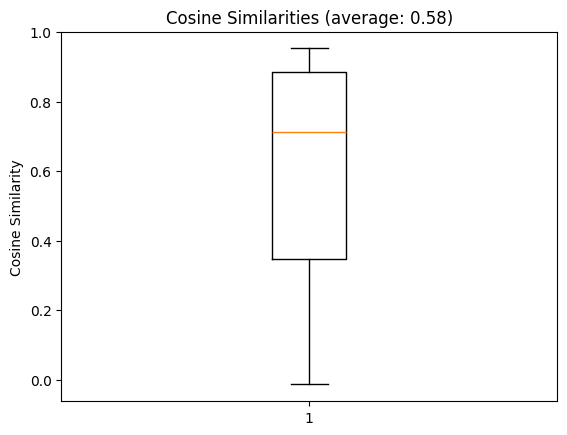

In [47]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim

embed_model = SentenceTransformer("all-MiniLM-L12-v2")


def get_similarity(
    human_answers: str | List[str],
    model_answers: str | List[str],
    embed_model: SentenceTransformer = embed_model,
) -> List[float]:
    """
    Get the cosine similarity between the human answer and the model answer for each pair of answers in the list

    Args:
        human_answers (str or List[str]):
            list of human answers
        model_answers (str or List[str]):
            list of model answers
        model (SentenceTransformer, default: all-MiniLM-L12-v2):
            embedding model to use for sentence similarity

    Returns:
        similarities (float or List[float]):
            list of cosine similarities between the human answers and the model answers
    """
    similarities = []
    for human_answer, model_answer in zip(human_answers, model_answers):
        # get the embeddings for the answers
        human_answer_embedding = embed_model.encode(
            human_answer, convert_to_tensor=True, show_progress_bar=False
        )
        model_answer_embedding = embed_model.encode(
            model_answer, convert_to_tensor=True, show_progress_bar=False
        )

        # calculate the cosine similarity between the human answer and the model answer
        similarities.append(
            cos_sim(human_answer_embedding, model_answer_embedding).item()
        )

    return similarities


cosine_sims = get_similarity(human_answers, eval_results["model_answers"])
eval_results["cosine_similarities"] = cosine_sims
avg_sim = np.mean(cosine_sims)

# plot the distribution of cosine similarities
plt.boxplot(cosine_sims)
plt.title(f"Cosine Similarities (average: {avg_sim:.2f})")
plt.ylabel("Cosine Similarity")
plt.show()

The average cosine similarity is roughly 0.6, which is not bad considering the fact that the LLM is not trained on my knowledge base. However, this performance varies among 11 responses: the best is 0.95 and the worst is negative. In the next section, I discuss the reasons behind this variation: which type of question does the LLM tend to perform well on and which type it does not.

## Qualitative evaluation

In [49]:
from IPython.display import Markdown, display

# Sort the indices of the eval_results by cosine similarity
sorted_indices = np.argsort(eval_results["cosine_similarities"])[::-1]

# Display eval_reults in a numbered list
for i, index in enumerate(sorted_indices):
    cos_sim = eval_results["cosine_similarities"][index]
    question = eval_results["questions"][index]
    use_context = eval_results["is_model_generated"][index]
    human_answer = eval_results["human_answers"][index]
    model_answer = eval_results["model_answers"][index]
    display(
        Markdown(
            f"### {i+1}. **Cosine Similarity**: {cos_sim:.4f}\n"
            f"- **Question**: {question}\n"
            f"- **Generated by model?**: {use_context}\n"
            f"- **Human Answer**: {human_answer}\n\n"
            f"- **Model Answer**: {model_answer}\n"
        )
    )

### 1. **Cosine Similarity**: 0.9529
- **Question**: What does microenomics concern?
- **Generated by model?**: False
- **Human Answer**: Microeconomics is the study of how individuals, households, and firms make decisions about using limited resources—not just buying, selling, or producing them

- **Model Answer**: Microeconomics concerns the study of how individuals, households, and firms make decisions about using limited resources.


### 2. **Cosine Similarity**: 0.9399
- **Question**: In marketing 4P, what factors affect price?
- **Generated by model?**: True
- **Human Answer**: Several factors affect price: supply costs, discounts, competitors' prices. However, the optimal approach should be customer-based. We want to quantify the range of willingness to pay and change prices by segments. If we just do cost-based pricing, we miss out on customer needs.

- **Model Answer**: Several factors affect price: supply costs, discounts, competitors' prices. However, the optimal approach should be customer-based. We want to quantify the range of willingness to pay and change prices by segments. If we just do cost-based pricing, we miss out on customer needs. Other pricing strategies include outcome-based pricing, value-based pricing, bundling, upselling, and cross-selling.


### 3. **Cosine Similarity**: 0.8892
- **Question**: Why do we need to change the basis?
- **Generated by model?**: False
- **Human Answer**: The change of basis is necessary when we want to work with a different linear transformation or when we want to represent vectors in a different basis. It allows us to convert matrices and vectors from one basis to another. 

- **Model Answer**: Changing the basis is necessary in linear algebra for various reasons. One common reason is to simplify calculations and analysis. By changing the basis, we can often find a new set of basis vectors that make certain operations or transformations easier to understand and compute. Additionally, changing the basis can help us gain insight into the structure and properties of a vector space or linear transformation. It allows us to view vectors and transformations from different perspectives, which can be useful in solving problems and proving theorems. Overall, changing the basis is a powerful tool in linear algebra that helps us analyze and manipulate vectors and linear transformations in a more convenient and insightful way.


### 4. **Cosine Similarity**: 0.8840
- **Question**: Provide an overview of most important mechanisms for transformers.
- **Generated by model?**: True
- **Human Answer**: The most important mechanisms for transformers include self-attention mechanisms, multi-head attention, positional encoding, and feedforward neural networks. These mechanisms enable transformers to handle sequence data effectively, by learning the relationships between different elements of the sequence and the relative positions of these elements, and by paying attention to relevant parts of the sequence when making predictions.

- **Model Answer**: The most important mechanisms for transformers are:
1. Attention Mechanism: Transformers use attention mechanism to compute attention scores for each word in the sequence, determining how much it should focus on other words.
2. Self-attention: Transformers use self-attention to weigh the importance of different parts of the input when making predictions.
3. Input Embedding & Output Embedding: Each input sequence is tokenized as a word embedding, which is a dense vector of real numbers.
4. Residual Connection: Transformers use residual connection to help with the flow of information through the network.
5. Layer Normalization: Transformers use layer normalization to normalize the activations and stabilize training.
6. Masked Multi-Head Attention: Transformers use masked multi-head attention in the decoder to prevent it from looking at future positions in the sequence during training.

These mechanisms are key components of the Transformer architecture, which is a model of self-supervised learning that can handle sequence data effectively.


### 5. **Cosine Similarity**: 0.7640
- **Question**: How do I interpret regression coefficients?
- **Generated by model?**: False
- **Human Answer**: Slope b indicates that, for every unit increase in the predictor, we would expect b unit increase in the dependent variable.
 Intercept a is the value of dependent variable when all independent variables are set to 0. 
Error term (residual): the difference between the predicted and actual value (aka the uncertainty of the regression model. 
 Interaction term indicate whether there is a joint effect of some predictors on the variable.

- **Model Answer**: The interpretation of regression coefficients depends on the specific context and variables involved in the regression analysis. In general, the slope coefficient represents the change in the dependent variable for a one-unit increase in the independent variable, while holding all other independent variables constant. The intercept represents the estimated value of the dependent variable when all independent variables are set to zero. The error term (residual) represents the difference between the observed and predicted values of the dependent variable. The prediction interval is a range of values within which we expect the true value of the dependent variable to fall with a certain level of confidence. It is important to note that correlation does not imply causation, and hypothesis testing is used to determine if a coefficient is statistically significant, indicating a true correlation between variables. The p-value is the probability of observing such a substantial association between the predictor and the response by chance, assuming the null hypothesis is true. If the null hypothesis is rejected, it can be concluded that the coefficient is statistically significant.


### 6. **Cosine Similarity**: 0.7130
- **Question**: How should I evaluate a synthetic control case study?
- **Generated by model?**: False
- **Human Answer**: We can conduct placebo studies to ensure that the treatment effect is only observed by the treated unit in the specific time. This can be done through in-time placebo (reapplying the treatment to a different time period before the intervention) or in-space placebo (reapplying the treatment to a comparison unit).
 Further, we can perform robustness tests by iteratively excluding each comparison unit with positive weights (leave-one-out), reconstructing the synthetic control, and re-estimating the treatment effect to see if the conclusion still holds.

- **Model Answer**: To evaluate a synthetic control case study, there are several steps you can take:

1. Assess the validity of the synthetic control by checking the similarity of the treated unit's pre-treatment characteristics to the synthetic control.

2. Compare the actual post-treatment outcome of the treated unit with the counterfactual outcome predicted by the synthetic control.

3. Refine the synthetic control by adjusting the set of covariates, exploring alternative weighting schemes, or incorporating additional control units.

4. Conduct placebo studies to ensure that the treatment effect is only observed by the treated unit in the specific time. This can be done through in-time placebo studies, where the treatment is reapplied to a different time period before the intervention, or in-space placebo studies, where the treatment is reapplied to a comparison unit.

5. Perform robustness tests by iteratively excluding each comparison unit with positive weights (leave-one-out), reconstructing the synthetic control, and re-estimating the treatment effect. This helps determine if the conclusion still holds when specific comparison units are excluded.

6. Consider the tradeoff between the number of comparison units and the goodness of fit. Using weighted combinations of units generally increases the goodness of fit, but it's important to find a balance.

7. Calculate the p-value, which is the sum of squared difference between the synthetic control and treated unit pre-treatment.

These steps can help evaluate the effectiveness and reliability of a synthetic control case study.


### 7. **Cosine Similarity**: 0.4775
- **Question**: Based on the NLP techniques I already learned, what should I learn next?
- **Generated by model?**: False
- **Human Answer**: Delve deeper into advanced transformer models beyond BERT
Learn how to fine-tune pre-trained models like BERT or GPT for specific downstream tasks
Explore models that handle multiple modalities, such as images and text. Models like CLIP (Contrastive Language-Image Pre-training) and ViT (Vision Transformer) can provide insights into cross-modal representations.
Gain an understanding of ethical considerations and biases in NLP models. Explore methods to detect and mitigate biases in language models.

- **Model Answer**: Based on the NLP techniques you already learned, you should learn about the attention mechanism in sequence-to-sequence models. The attention mechanism allows the model to focus on relevant parts of the input sequence when generating the output sequence. This can improve the performance of sequence-to-sequence models, especially when dealing with long sequences. Additionally, you can explore named entity recognition techniques using libraries such as NLTK, SpaCy, or Polyglot. Named entity recognition is a useful technique for identifying important named entities in text, which can be helpful for various NLP tasks.


### 8. **Cosine Similarity**: 0.4067
- **Question**: What is a probability?
- **Generated by model?**: False
- **Human Answer**: A naive definition: Probability presents how likely an event is to occur with a number between 0 and 1, where, roughly speaking, 0 indicates impossibility of the event and 1 indicates certainty. The higher the probability of an event, the more likely it is that the event will occur.


- **Model Answer**: The probability of an event occurring given another event occurred is called conditional probability. It is denoted as P(A|B), which represents the probability of event A happening given that event B has already occurred. The conditional probability can be calculated using the formula P(A|B) = P(A and B) / P(B), where P(A and B) is the probability of both events A and B happening, and P(B) is the probability of event B happening. In the given example of drawing cards, the conditional probability would be the probability of drawing a red card as the second card, given that the first card drawn is a heart.


### 9. **Cosine Similarity**: 0.2894
- **Question**: From my notes, what did I learn in the business classes?
- **Generated by model?**: False
- **Human Answer**: In marketing, you learned about customer-centric thinking, such as customer segmentation and customer lifetime value, and popular frameworks, such as five competitive forces and marketing 4Ps.
In accounting, you learned about three financial statements that are used to evaluate a company's financial performance: balance sheet, income statement, and cash flow statement.
 In finance, you learned about the time value of money, valuation, options, and risk management. You also learned the basics of economics.

- **Model Answer**: The accounts that would be increased with a Credit are Revenue, Notes Payable, and Additional Paid-in-Capital. Paying cash to reduce a liability would be represented by a journal entry that debits the liability account and credits the cash account.


### 10. **Cosine Similarity**: 0.0480
- **Question**: What are some methods to measure how well a Bayesian model estimates the posterior?
- **Generated by model?**: False
- **Human Answer**: 1. Model evidence: Quantifies the probability of observed data under the model, indicating how well a Bayesian model fits the observed data.
 2. Kullback-Leibler divergence: Quantifies the difference between two probability distributions, typically a true/observed distribution and an estimated model distribution.
 3. Log Point-wise Predictive Density (LPPD): Represents the difference between the KL divergence of the target and model and the KL divergence of the target and itself. It is a measure of how well the model fits the data.

- **Model Answer**: The answer is not available and I will use my own knowledge to answer the question.


### 11. **Cosine Similarity**: -0.0136
- **Question**: How to identify which critical point is local minimum or maximum?
- **Generated by model?**: False
- **Human Answer**: We can use the second derivative test. If the second derivative is positive, the critical point is a local minimum. If the second derivative is negative, the critical point is a local maximum. If the second derivative is zero, the test is inconclusive.

- **Model Answer**: The answer is not available and I will use my own knowledge to answer the question.


- The system tends to perform very well (cosine similarity > 0.9) on questions that contain keywords in the metadata. For question “How to identify which critical point is local minimum or maximum?” I have a note called “critical point,” and for “In marketing 4P, what factors affect price?,” I have a note called “marketing 4Ps.” The retriever manages to grab the exact passage I copy my human answer from.
- It performs less well (cosine similarity: 0.7-0.8) when the LLM has to summarize across longer documents (question 3-4-6). 
- It performs quite bad (cosine similarity: 0.2 - 0.4) when it is asked to summarize across my documents and infer based on its knowledge (e.g. give advice) in questions 7 and 9. It is understandable though, but I can engineer prompt further.
- The LLM-generated answer to the question "What is a probability?" is about conditional probability, but the cosine similarity is medium (0.6).  This poses two problems:
	- Cosine similarity lacks as the sole metric to evaluate the performance of the system. The similarity between “probability” and “conditional probability” might have increased the score, although the answer is completely irrelevant. I need another systematic approach to quantify the relevance, potentially through `trulens_eval` with the use of LLM. 
	- Embedding-based retrieval (and even reranking) might not capture the context as well as the LLM. It’s more obvious when I run several times through the “What are some methods to measure how well a Bayesian model estimates the posterior?.” Sometimes the model can capture the keyword well, or sometimes it cannot. More advanced techniques are needed to increase the accuracy of the response.
- Even after engineering the prompt, I sometimes can’t get the model to answer the question outside of my knowledge base.


# Conclusion
In this assignment, I build a question answering system that can answer questions about my knowledge base (particularly my notes is Markdown), based on the retrieval augmented generation (RAG) framework. I evaluate the system using cosine similarity and qualitative assessment, comparing between my expected answer and the model answer for each of 11 questions. The system performs well on questions that contain keywords in the metadata, but less well on questions that require summarization across multiple documents. Further, the system performs poorly on questions that require the LLM to infer based on its knowledge.

## Limitations & Future work directions

- The system is not robust to questions that require the LLM to infer based on its knowledge. I can engineer the prompt further to improve the performance.
- I will improve further on this RAG pipeline, by incorporating more advanced techniques such as big-to-small retrieval, LLM-based reranking and LLM-based retrieval.
- Although I do iterate this pipeline by changing prompt and hyperparameters such as context window size, I did not have a systemized approach to do so. Additionally, cosine similarity is not a good sole metric to evaluate the performance of the system. In the next assignment, I will use LLM-powered `trulens_eval` to evaluate and record the performance of the system for each set of hyperparameters.
- I will experiment with an open-source, local LLM, to avoid sending private data to OpenAI 
- I focus on explaining the math behind transformer and only go over the high-level details of retriever. In the next assignment, I plan to elaborate more on the math behind the RAG framework, especially the retrieval model and the reranking model.
- And if I have more time, I will add more data to my knowledge base, such as PDFs (assignments & textbooks).

# Executive summary

In this assignment, I built a question answering system that can answer questions about my knowledge base. The system is built on the retrieval augmented generation (RAG) framework, which combines the strengths of a knowledge base with those of an LLM to produce more accurate and contextually relevant responses. I justify the advantages of RAG over fine-tuning, since I have a growing knowledge base. I then explain in details the building blocks for two components of RAG, retriever and generator, including the concepts of embedding, vector database, context window, transformer architecture, and attention mechanism. 

After building the RAG pipeline, I generate 11 question-answer pairs, and evaluate the model answers using cosine similarity and qualitative assessment. It achieves an average cosine similarity of 0.58; however, this performance varies among different types of questions. The system performs well on questions that contain keywords in the metadata, but less well on questions that require summarization across multiple documents. Further, it performs poorly on questions that require the LLM to infer based on its knowledge. I discuss the limitations of the system and future work directions to improve the performance.

# AI Statement

I use Github Copilot as the pair programmer for basic syntax (RAG pipeline is beyond its training scope). I also use a combination of external source and perplexity.ai to write the explanation for the transformer architecture and attention mechanism. 

# References
Alammar, J. (2019). _The illustrated transformer_. http://jalammar.github.io/illustrated-transformer/

AssemblyAI. (2021, November 27). _Transformers for beginners | What are they and how do they work_ [Video]. YouTube. https://www.youtube.com/watch?v=_UVfwBqcnbM

Lewis, P., Perez, E., Piktus, A., Petroni, F., Karpukhin, V., Goyal, N., Küttler, H., Lewis, M., Yih, W., Rocktäschel, T., Riedel, S., & Kiela, D. (2020). Retrieval-Augmented Generation for Knowledge-Intensive NLP tasks. _arXiv (Cornell University)_. https://arxiv.org/pdf/2005.11401

Liu, J. (2023, August 16). Using LLM’s for retrieval and reranking - LlamaIndex blog. _Medium_. https://blog.llamaindex.ai/using-llms-for-retrieval-and-reranking-23cf2d3a14b6

Liu, J., & Datta, A. (2023, November 29). _Building and Evaluating Advanced RAG with LlamaIndex and TruEra_. deeplearning.ai. https://www.deeplearning.ai/short-courses/building-evaluating-advanced-rag/

LlaMaIndex. (n.d.). _LlaMAIndex 0.9.9_. LlaMAIndex Documentation. https://docs.llamaindex.ai/en/stable

NexaNodeLabs. (2023, October 30). Fine-Tuning vs RAG: Choosing the Right Approach for Your Question-Answering System. _Medium_. https://medium.com/@nexanodelabs/fine-tuning-vs-rag-choosing-the-right-approach-for-your-question-answering-system-7c7fbf5d4131

Raschka, S. (2023, February 9). _Understanding and coding the Self-Attention Mechanism of large Language models from scratch_. Sebastian Raschka, PhD. https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html

SBERT. (2022). _Retrieve & Re-Rank_. Sentence-Transformers Documentation. https://www.sbert.net/examples/applications/retrieve_rerank/README.html

SBERT. (2023). _sentence-transformers/all-mpnet-base-v2_. Hugging Face. https://huggingface.co/sentence-transformers/all-mpnet-base-v2

Serrano, L., [Serrano.Academy]. (2023, August 31). _The math behind Attention: Keys, Queries, and Values matrices_ [Video]. YouTube. https://www.youtube.com/watch?v=UPtG_38Oq8o

Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is All you Need. _arXiv (Cornell University)_, _30_, 5998–6008. https://arxiv.org/pdf/1706.03762v5

Weng, L. (2023, January 27). The Transformer Family Version 2.0. _Lil’Log_. https://lilianweng.github.io/posts/2023-01-27-the-transformer-family-v2/

Yan, E. (2023, July 30). _Patterns for building LLM-based systems & products_. eugeneyan.com. https://eugeneyan.com/writing/llm-patterns/#retrieval-augmented-generation-to-add-knowledge
